In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats.mstats import winsorize
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
# https://www.kaggle.com/htagholdings/property-sales
data = pd.read_csv('raw_sales.csv', parse_dates=['datesold'])
data['year'] = data['datesold'].dt.year
data.head()

,datesold,postcode,price,propertyType,bedrooms,year
0,2007-02-07,2607,525000,house,4,2007
1,2007-02-27,2906,290000,house,3,2007
2,2007-03-07,2905,328000,house,3,2007
3,2007-03-09,2905,380000,house,4,2007
4,2007-03-21,2906,310000,house,3,2007


In [3]:
data.describe()

,postcode,price,bedrooms,year
count,29580.000000,2.958000e+04,29580.000000,29580.000000
mean,2730.249730,6.097363e+05,3.250169,2014.625321
std,146.717292,2.817079e+05,0.951275,2.964343
min,2600.000000,5.650000e+04,0.000000,2007.000000
25%,2607.000000,4.400000e+05,3.000000,2013.000000
50%,2615.000000,5.500000e+05,3.000000,2015.000000
75%,2905.000000,7.050000e+05,4.000000,2017.000000
max,2914.000000,8.000000e+06,5.000000,2019.000000


In [4]:
# Итого имеем три переменные для исследования price, propertyType, bedrooms
# price была приведена к категориальному типу (разделена на корзины), остальные признаки можно оставить такими как есть

split_year = 2016
data['price'] = winsorize(data['price'],limits = (0.05,0.05))

data['price_bins'] = pd.cut(data['price'], bins = 8)

data['type'] = data['year'].apply(lambda year: 'target' if year <= split_year else f'base')
data.head()

,datesold,postcode,price,propertyType,bedrooms,year,price_bins,type
0,2007-02-07,2607,525000,house,4,2007,"(515000.0, 610000.0]",target
1,2007-02-27,2906,325000,house,3,2007,"(324240.0, 420000.0]",target
2,2007-03-07,2905,328000,house,3,2007,"(324240.0, 420000.0]",target
3,2007-03-09,2905,380000,house,4,2007,"(324240.0, 420000.0]",target
4,2007-03-21,2906,325000,house,3,2007,"(324240.0, 420000.0]",target


In [5]:
price_distribution = pd.DataFrame(
                                    data.groupby(by = 'type')['price_bins']
                                                             .value_counts(normalize = True)
                                                             .mul(100)
                                                             .rename('percentage')
                                                             .reset_index()
                                                             .sort_values(by='type', ascending = False)
                                )

In [6]:
price_distribution

,type,price_bins,percentage
8,target,"(420000.0, 515000.0]",25.338452
9,target,"(324240.0, 420000.0]",22.029703
10,target,"(515000.0, 610000.0]",19.731259
11,target,"(610000.0, 705000.0]",12.911699
12,target,"(705000.0, 800000.0]",7.541928
13,target,"(990000.0, 1085000.0]",5.132350
14,target,"(800000.0, 895000.0]",4.637300
15,target,"(895000.0, 990000.0]",2.677309
0,base,"(515000.0, 610000.0]",17.906787
1,base,"(324240.0, 420000.0]",17.334424


## 1. Зачем?
##### Чтобы определить являются ли отклонения в выборке допустимыми

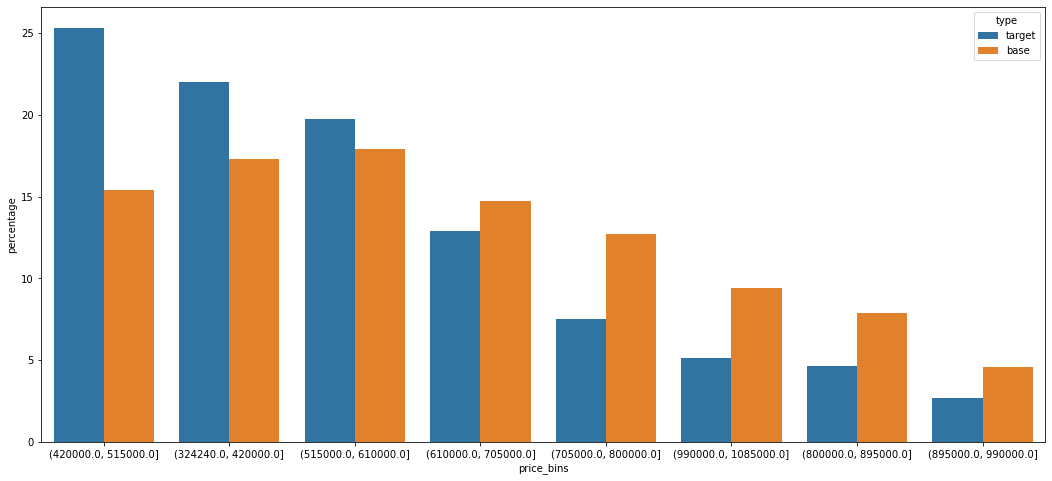

In [7]:
fig, ax = plt.subplots(ncols=1, figsize = (18,8))
sns.barplot(x = 'price_bins', y = 'percentage', data = price_distribution, hue = 'type', ax = ax);

## 2. Расчет Population Stability Index (PSI)

## $$\sum^N_{l=0}(y_{ti} - y_{bi})\ln\frac{y_{ti}}{y_{bi}}$$

In [8]:
price_distribution_pivot = pd.pivot_table(
                                            price_distribution, 
                                            values = 'percentage', 
                                            index = ['price_bins'], 
                                            columns = ['type']
                                        )

price_distribution_pivot = price_distribution_pivot.sort_index(axis='columns',ascending = False)

price_distribution_pivot['target-base_percent'] = price_distribution_pivot['target'] - price_distribution_pivot['base']
price_distribution_pivot['target/base'] = price_distribution_pivot['target'] / price_distribution_pivot['base']
price_distribution_pivot['ln(target/base)'] = np.log(price_distribution_pivot['target/base'])
price_distribution_pivot['PSI'] = price_distribution_pivot['target-base_percent'] / 100  * price_distribution_pivot['ln(target/base)']

In [9]:
price_distribution_pivot

type,target,base,target-base_percent,target/base,ln(target/base),PSI
price_bins,,,,,,
"(324240.0, 420000.0]",22.029703,17.334424,4.695279,1.270864,0.239697,0.011254
"(420000.0, 515000.0]",25.338452,15.382257,9.956195,1.647252,0.499108,0.049692
"(515000.0, 610000.0]",19.731259,17.906787,1.824472,1.101887,0.097024,0.001770
"(610000.0, 705000.0]",12.911699,14.758790,-1.847091,0.874848,-0.133705,0.002470
"(705000.0, 800000.0]",7.541928,12.714636,-5.172708,0.593169,-0.522276,0.027016
"(800000.0, 895000.0]",4.637300,7.890433,-3.253133,0.587712,-0.531519,0.017291
"(895000.0, 990000.0]",2.677309,4.568684,-1.891375,0.586013,-0.534413,0.010108
"(990000.0, 1085000.0]",5.132350,9.443990,-4.311640,0.543451,-0.609815,0.026293


In [10]:
PSI = sum(price_distribution_pivot['PSI'])
print(f'PSI: {PSI}')

PSI: 0.14589410748334738


## 3. Интерпретация результатов

|PSI Value|Inference|Action
|------|------|------|
|Less than 0.1|Insignificant change|No action required|
|0.1 – 0.25|Some minor change|Check other scorecard monitoring metrics|
|Greater than 0.25|Major shift in population|Need to delve deeper|

## 4. Бонус (Готовая функция)

In [11]:
price_distribution.sort_values(by = ['type', 'price_bins'], axis = 0, inplace = True)
price_distribution

,type,price_bins,percentage
1,base,"(324240.0, 420000.0]",17.334424
2,base,"(420000.0, 515000.0]",15.382257
0,base,"(515000.0, 610000.0]",17.906787
3,base,"(610000.0, 705000.0]",14.758790
4,base,"(705000.0, 800000.0]",12.714636
6,base,"(800000.0, 895000.0]",7.890433
7,base,"(895000.0, 990000.0]",4.568684
5,base,"(990000.0, 1085000.0]",9.443990
9,target,"(324240.0, 420000.0]",22.029703
8,target,"(420000.0, 515000.0]",25.338452


In [12]:
def population_stability_index(target_percentages, base_percentages):
    PSI = sum(((target_percentages - base_percentages) / 100) * np.log(target_percentages / base_percentages))    
    return PSI

In [13]:
target_percentages = price_distribution[price_distribution['type'] == 'target']['percentage'].values
base_percentages = price_distribution[price_distribution['type'] == 'base']['percentage'].values

In [14]:
population_stability_index(target_percentages, base_percentages)

0.14589410748334738